# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: *** 313581654 316298876 ***

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [105]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [106]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7f72f651e250>, <__main__.Node at 0x7f72f651e7d0>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [107]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [108]:
#############################################################################
# TODO: Find the columns with missing values and remove them from the data.#
#############################################################################

#There is not any of missing values, but if there is any missing values...
data.dropna(axis = 1, inplace=True)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [109]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X, y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [110]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [111]:
def calc_gini(data: np.ndarray) -> float:
    """
    Calculate gini impurity measure of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the gini impurity.
    """
    gini = 0.0
    ###########################################################################
    #
    ###########################################################################

    vals_count = np.unique(data[:, -1], return_counts=True)[1]
    probs = vals_count / data.shape[0]
    gini = 1 - np.sum(np.power(probs, 2))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [112]:
def calc_entropy(data: np.ndarray) -> float:
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.
    """
    entropy = 0.0
    ###########################################################################
    #
    ###########################################################################

    vals_count = np.unique(data[:, -1], return_counts=True)[1]
    probs = vals_count / data.shape[0]
    entropy = -np.sum(probs * np.log2(probs))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [113]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [114]:
def goodness_of_split(data: np.ndarray, feature: int, impurity_func, gain_ratio: bool = False) -> float:
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).
    """
    ###########################################################################
    #
    ###########################################################################

    # Trim the relative data
    if gain_ratio:
        impurity_func = calc_entropy

    _data = data[:, [feature, -1]]

    # Sorting by feature's values
    _data_sorted = _data[_data[:, 0].argsort()]

    # Count feature's values
    _data_uniques_count = np.unique(_data_sorted[:, 0], return_counts=True)[1]

    # Split our relevant data by feature's values (output: labels)
    _data_split_by_feature_vals = np.split(_data_sorted[:, -1], np.cumsum(_data_uniques_count)[:-1])

    # Calculate impurities for each of the values of the feature
    impurities = np.array(list(map(lambda x: impurity_func(x[:, None]), _data_split_by_feature_vals)))

    # Calculate impurity of the relative data
    impurity = impurity_func(_data)

    # Calculate goodness :)
    goodness = impurity - np.sum((_data_uniques_count / _data.shape[0]) * impurities)

    if gain_ratio:
        # If the shape equlas to 1 -> calc_entropy will return 0 -> goodness be nan -> error on building tree function
        if _data_uniques_count.shape[0] == 1:
            goodness = 0
        else:
            split_info = calc_entropy(_data[:, 0][:, None])
            goodness /= split_info

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [115]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic
    functionality as described above. It is highly recommended that you
    first read and understand the entire exercise before diving into this class.
    """

    def __init__(self,
                 feature: int,
                 parent_splitter_value: float = None,
                 label: str = None,
                 depth: int = None,
                 data: np.ndarray = None):
        self.feature = feature  # column index of criteria being tested
        self.parent_splitter_value = parent_splitter_value
        self.label = label
        self.depth = depth
        self.data = data.copy()

        self.children_values = {}
        self.children = []
        self.parent = None

    def add_child(self, node):
        self.children.append(node)
        self.children_values.update({
            node.parent_splitter_value: self.children[-1]
        })
        
        node.parent = self

    def is_leaf(self) -> bool:
        return len(self.children) == 0

In [116]:
def build_tree(data: np.ndarray, impurity, gain_ratio: bool = False, chi: float = 1,
               max_depth: int = 1000, parent_splitter_value: str = None, node_depth: int = 0,
               p_value: float = 1) -> DecisionNode:
    """
    Build a tree using the given impurity measure and training dataset.
    You are required to fully grow the tree until all leaves are pure.

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    #
    ###########################################################################

    node_impurity = impurity(data)

    labels, label_counts = np.unique(data[:, -1], return_counts=True)
    label_max = labels[np.argmax(label_counts)]

    goodnesses = [goodness_of_split(data=data,
                                    feature=f_idx,
                                    impurity_func=impurity,
                                    gain_ratio=gain_ratio)
                  for f_idx in range(data.shape[1] - 1)]

    max_feature_idx = np.argmax(goodnesses)

    iszero_impurity = np.isclose(node_impurity, 0)
    iszero_max_feature_goodness = np.isclose(goodnesses[max_feature_idx], 0)

    prune_chi_square = False
    if chi and 1 > p_value:
        chi_square = get_chi_square(dataset=data, feature=max_feature_idx)

        num_of_vals = len(np.unique(data[:, max_feature_idx]))
        # degree_of_freedom = 2 --> 1 * (num_of_vals - 1)
        degree_of_freedom = num_of_vals - 1
        if degree_of_freedom > 0:
            prune_chi_square = chi_square <= chi_table.get(degree_of_freedom).get(p_value)

    if iszero_impurity or iszero_max_feature_goodness or node_depth > max_depth or prune_chi_square:
        return DecisionNode(feature=None,
                            parent_splitter_value=parent_splitter_value,
                            label=label_max,
                            depth=node_depth,
                            data=data)

    root = DecisionNode(feature=max_feature_idx,
                        parent_splitter_value=parent_splitter_value,
                        label=label_max,
                        depth=node_depth,
                        data=data)

    unique_vals = np.unique(data[:, max_feature_idx])
    for unique_val in unique_vals:
        child_data = data[data[:, max_feature_idx] == unique_val]
        child = build_tree(data=child_data,
                           impurity=impurity,
                           gain_ratio=gain_ratio,
                           chi=chi,
                           max_depth=max_depth,
                           parent_splitter_value=unique_val,
                           node_depth=node_depth + 1,
                           p_value=p_value)

        root.add_child(node=child)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [117]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [118]:
def predict(node: DecisionNode, instance: np.ndarray) -> str:
    """
    Predict a given instance using the decision tree

    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element
                of this vector is the label of the instance.

    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################

    while not node.is_leaf():
        att_val = instance[node.feature]

        if att_val not in node.children_values:
            break

        node = node.children_values[att_val]

    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.label

In [119]:
def calc_accuracy(node: DecisionNode, dataset: np.ndarray) -> float:
    """
    Predict a given dataset using the decision tree

    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated

    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    #
    ###########################################################################

    correct = 0
    for instance in dataset:
        if predict(node=node, instance=instance).__eq__(instance[-1]):
            correct += 1

    accuracy = (correct / dataset.shape[0]) * 100

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [120]:
print("Tree gini\t\t\tTrain:",
      f'{np.round(calc_accuracy(node=tree_gini, dataset=X_train), 2)}%',
      "Test:",
      f'{np.round(calc_accuracy(node=tree_gini, dataset=X_test), 2)}%')
print("Tree entropy\t\t\tTrain:",
      f'{np.round(calc_accuracy(node=tree_entropy, dataset=X_train), 2)}%',
      "Test:",
      f'{np.round(calc_accuracy(node=tree_entropy, dataset=X_test), 2)}%')
print("Tree entropy with gain ratio\tTrain:",
      f'{np.round(calc_accuracy(node=tree_entropy_gain_ratio, dataset=X_train), 2)}%',
      "Test:",
      f'{np.round(calc_accuracy(node=tree_entropy_gain_ratio, dataset=X_test), 2)}%')

Tree gini			Train: 99.25% Test: 77.5%
Tree entropy			Train: 99.41% Test: 77.25%
Tree entropy with gain ratio	Train: 99.64% Test: 78.53%


## Post pruning

Iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, create a plot of the training and testing accuracies as a function of the number of nodes in the tree. (15 points)

In [121]:
def count_nodes(node: DecisionNode) -> int:
    """
    Count the number of node in a given tree

    Input:
    - node: a node in the decision tree.

    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    if node.is_leaf():
        return 1

    count = 1
    for child in node.children:
        count += count_nodes(child)

    return count

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [122]:
def get_nodes_with_leafs(node: DecisionNode) -> list:
    lst = []

    for child in node.children:
        lst += get_nodes_with_leafs(node=child)

    for child in node.children:
        if child.is_leaf():
            lst += [node]
            break

    return lst

In [123]:
def post_pruning(node: DecisionNode, test_data: np.ndarray, train_data: np.ndarray) -> (float, int):
    counts = [count_nodes(node=node)]
    test_acc = [calc_accuracy(node=node, dataset=test_data)]
    train_acc = [calc_accuracy(node=node, dataset=train_data)]

    while len(node.children) != 0:
        nodes_with_leafs = get_nodes_with_leafs(node=node)

        accs = []
        for idx in range(len(nodes_with_leafs)):
            tmp = nodes_with_leafs[idx].children
            nodes_with_leafs[idx].children = []

            accs.append(calc_accuracy(node=node, dataset=test_data))

            nodes_with_leafs[idx].children = tmp

        max_idx = np.argmax(accs)
        nodes_with_leafs[max_idx].children = []

        counts += [count_nodes(node=node)]
        test_acc += [accs[max_idx]]
        train_acc += [calc_accuracy(node=node, dataset=train_data)]

    max_acc = np.max(test_acc)
    best_tree_size = counts[np.where(test_acc == max_acc)[0][-1]]

    plt.plot(counts, train_acc, label="Train Dataset Accuracy")
    plt.plot(counts, test_acc, label="Test Dataset Accuracy")
    plt.scatter(best_tree_size, max_acc, color="r", linewidths=20, label=f'The Best Tree! ({best_tree_size})')

    plt.title("Test, Train Accuracy vs. Nodes Count", fontsize=24)
    plt.xlabel("Nodes Count", fontsize=16)
    plt.ylabel("Accuracy (percentage)]", fontsize=16)

    plt.legend()
    plt.show()

    return max_acc, best_tree_size

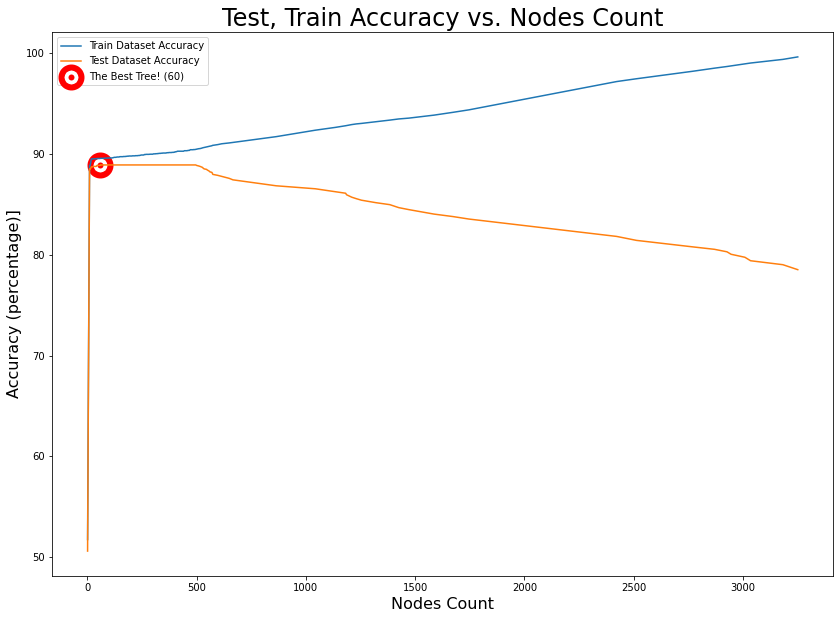

In [124]:
best_post_pruning_acc, best_post_pruning_tree_size = post_pruning(node=tree_entropy_gain_ratio, test_data=X_test, train_data=X_train)

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle. (15 points)

In [125]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

In [126]:
def get_max_depth(node: DecisionNode) -> int:
    if node is None:
        return 0
    else:
        depths = [0]
        for child in node.children:
            depths.append(get_max_depth(node=child))

        return max(depths) + 1

In [127]:
def get_chi_square(dataset: np.ndarray, feature: int) -> float:
    _data = dataset[:, [feature, -1]]
    unique_attributes = np.unique(_data[:, 0])

    instances_count = _data.shape[0]

    count_p = (_data[:, -1] == "p").sum()
    count_e = instances_count - count_p

    prob_0 = count_p / instances_count
    prob_1 = count_e / instances_count

    chi_square = 0
    for att in unique_attributes:
        df = (_data[:, 0] == att).sum()
        pf = ((_data[:, 0] == att) & (_data[:, -1] == "p")).sum()
        nf = df - pf

        e0 = df * prob_0
        e1 = df * prob_1

        chi_square += (np.power(pf - e0, 2) / e0) + (np.power(nf - e1, 2) / e1)

    return chi_square

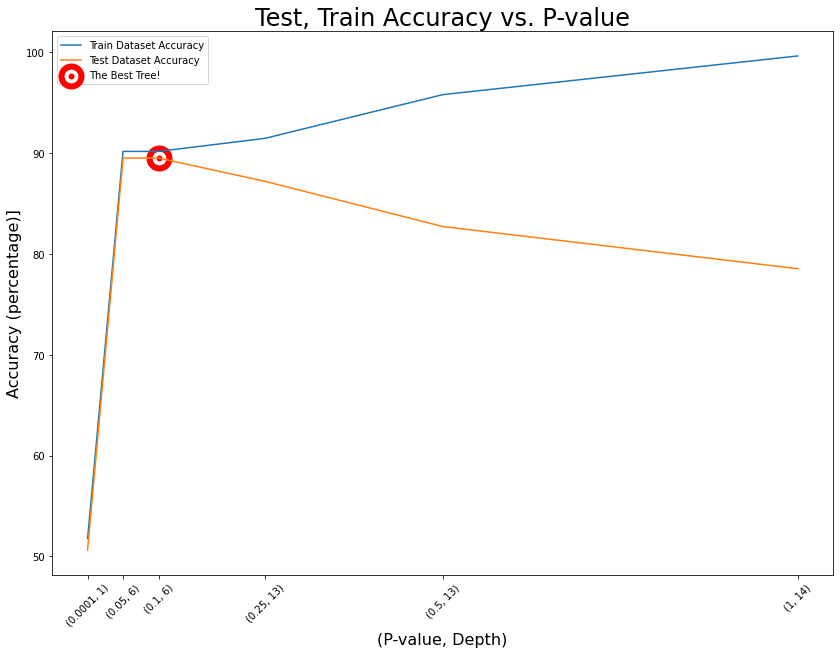

In [128]:
p_values = [1, 0.5, 0.25, 0.1, 0.05, 0.0001]
train_accs = []
test_accs = []
depths = []

for p_value in p_values:
    tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, p_value=p_value)

    depths.append(get_max_depth(node=tree))
    train_accs.append(calc_accuracy(node=tree, dataset=X_train))
    test_accs.append(calc_accuracy(node=tree, dataset=X_test))
    
best_p_value_idx = np.argmax(test_accs)

plt.plot(p_values, train_accs, label="Train Dataset Accuracy")
plt.plot(p_values, test_accs, label="Test Dataset Accuracy")
plt.scatter(p_values[best_p_value_idx], test_accs[best_p_value_idx], color="r", linewidths=20, label="The Best Tree!")

plt.title("Test, Train Accuracy vs. P-value", fontsize=24)
plt.xticks(p_values, [f'({p_values[_]}, {depths[_]})' for _ in range(len(depths))], rotation=45)
plt.xlabel("(P-value, Depth)", fontsize=16)
plt.ylabel("Accuracy (percentage)]", fontsize=16)

plt.legend()
plt.show()

In [129]:
p_values[best_p_value_idx], test_accs[best_p_value_idx]

(0.1, 89.51255539143278)

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [130]:
def build_best_post_pruning_tree(test_data: np.ndarray, train_data: np.ndarray, best_acc: float, tree_size: int) -> DecisionNode:
    node = build_tree(data=train_data, impurity=calc_entropy, gain_ratio=True)

    counts = [count_nodes(node=node)]
    test_acc = [calc_accuracy(node=node, dataset=test_data)]
    train_acc = [calc_accuracy(node=node, dataset=train_data)]

    while len(node.children) != 0:
        nodes_with_leafs = get_nodes_with_leafs(node=node)

        accs = []
        for idx in range(len(nodes_with_leafs)):
            tmp = nodes_with_leafs[idx].children
            nodes_with_leafs[idx].children = []

            accs.append(calc_accuracy(node=node, dataset=test_data))

            if accs[-1] == best_acc:
                if tree_size == count_nodes(node=node):
                    return node

            nodes_with_leafs[idx].children = tmp

        max_idx = np.argmax(accs)
        nodes_with_leafs[max_idx].children = []

        counts += [count_nodes(node=node)]
        test_acc += [accs[max_idx]]
        train_acc += [calc_accuracy(node=node, dataset=train_data)]

In [131]:
tree_post_pruning = build_best_post_pruning_tree(test_data=X_test, train_data=X_train, best_acc=best_post_pruning_acc, tree_size=best_post_pruning_tree_size)
tree_chi = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, chi=1, p_value=p_values[best_p_value_idx])

In [132]:
calc_accuracy(node=tree_post_pruning, dataset=X_test)

88.92171344165436

In [133]:
calc_accuracy(node=tree_chi, dataset=X_test)

89.51255539143278

## Number of Nodes

Of the two trees above we will choose the one with fewer nodes. Complete the function counts_nodes and print the number of nodes in each tree. (5 points) 

In [134]:
def count_nodes(node: DecisionNode) -> int:
    """
    Count the number of node in a given tree

    Input:
    - node: a node in the decision tree.

    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    if node.is_leaf():
        return 1

    count = 1
    for child in node.children:
        count += count_nodes(child)

    return count

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [135]:
count_nodes(node=tree_post_pruning)

60

In [136]:
count_nodes(node=tree_chi)

55

## Print the tree

Complete the function `print_tree` and execute it on your chosen tree. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [137]:
# you can change the function signeture
def print_tree(node: DecisionNode, depth: int = 0, parent_feature: str = 'ROOT', feature_val: str = 'ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    if depth == 0:
        print(f"[ROOT: feature=X{node.feature}],")
    else: 
        print(f'{" " * depth}[X{parent_feature}={feature_val}, feature=X{node.feature}],')

    if node.is_leaf():
        labels, labels_counts = np.unique(node.data[:, -1], return_counts=True)
        p = ''
        for i in range(len(labels)):
            p += "[{}:{}]".format(labels[i], labels_counts[i])
        print(f'{" " * depth}[X{parent_feature}={feature_val}, leaf]: ' + p)
        return
    
    for child in node.children:
        print_tree(child, child.depth, node.feature, child.parent_splitter_value)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [139]:
print_tree(node=tree_post_pruning)

[ROOT: feature=X4],
 [X4=a, feature=X2],
 [X4=a, leaf]: [e:273][p:31]
 [X4=c, feature=X6],
 [X4=c, leaf]: [e:10][p:137]
 [X4=f, feature=X10],
  [X10=f, feature=X2],
  [X10=f, leaf]: [e:14][p:91]
  [X10=k, feature=X11],
   [X11=k, feature=X7],
   [X11=k, leaf]: [e:118][p:951]
   [X11=s, feature=X1],
    [X1=s, feature=X0],
     [X0=f, feature=X2],
      [X2=e, feature=X13],
       [X13=p, feature=XNone],
       [X13=p, leaf]: [p:4]
       [X13=w, feature=X20],
        [X20=d, feature=XNone],
        [X20=d, leaf]: [p:2]
        [X20=l, feature=XNone],
        [X20=l, leaf]: [e:1]
      [X2=n, feature=XNone],
      [X2=n, leaf]: [p:10]
     [X0=k, feature=X20],
     [X0=k, leaf]: [e:6][p:11]
     [X0=x, feature=X13],
     [X0=x, leaf]: [e:5][p:16]
    [X1=y, feature=X20],
    [X1=y, leaf]: [e:4][p:43]
  [X10=s, feature=X19],
  [X10=s, leaf]: [e:22][p:310]
 [X4=l, feature=X1],
  [X1=f, feature=X0],
  [X1=f, leaf]: [e:19][p:1]
  [X1=s, feature=X2],
   [X2=w, feature=X18],
    [X18=k, featu

In [138]:
print_tree(node=tree_chi)

[ROOT: feature=X4],
 [X4=a, feature=XNone],
 [X4=a, leaf]: [e:273][p:31]
 [X4=c, feature=XNone],
 [X4=c, leaf]: [e:10][p:137]
 [X4=f, feature=X10],
  [X10=f, feature=X2],
   [X2=b, feature=XNone],
   [X2=b, leaf]: [e:8][p:30]
   [X2=g, feature=XNone],
   [X2=g, leaf]: [e:5][p:26]
   [X2=w, feature=XNone],
   [X2=w, leaf]: [e:1][p:35]
  [X10=k, feature=XNone],
  [X10=k, leaf]: [e:134][p:1037]
  [X10=s, feature=XNone],
  [X10=s, leaf]: [e:22][p:310]
 [X4=l, feature=X1],
  [X1=f, feature=XNone],
  [X1=f, leaf]: [e:19][p:1]
  [X1=s, feature=XNone],
  [X1=s, leaf]: [e:94][p:16]
  [X1=y, feature=XNone],
  [X1=y, leaf]: [e:159][p:10]
 [X4=m, feature=XNone],
 [X4=m, leaf]: [e:2][p:25]
 [X4=n, feature=X7],
  [X7=b, feature=X18],
   [X18=b, feature=XNone],
   [X18=b, leaf]: [e:34][p:2]
   [X18=k, feature=XNone],
   [X18=k, leaf]: [e:843][p:93]
   [X18=n, feature=XNone],
   [X18=n, leaf]: [e:882][p:105]
   [X18=o, feature=X19],
    [X19=c, feature=XNone],
    [X19=c, leaf]: [e:12][p:4]
    [X19=v